In [23]:
from sqlalchemy import create_engine
import pandas as pd

def query_features():
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        features = pd.read_sql(
        """
        SELECT 
            f.departure_was_delayed_15 as delayed,
            f.airport as departure_airport,
            f.departure_month as month,
            f.departure_date as date,
            f.departure_hod as hour_of_departure,
            f.carrier as carrier,
            f.distance as flight_distance,
            f.elapsed_time_scheduled as elapsed_time,
            f.hourly_visibility as visibility,
            f.hourly_dry_bulb_temp_f as temperature_f,
            f.hourly_precipitation as percipitation,
            f.hourly_wind_speed as wind_speed,
            f.hourly_wind_gust_speed as gust_speed,
            f.hourly_station_pressure
        FROM 
            features AS f
        """, 
        conn)
    
    for col in ['carrier', 'departure_airport']:
        features = features.drop(col, axis=1)
        #features[col] = features[col].astype('category')
    
    return pd.get_dummies(features, drop_first=True)

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
features = query_features()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74588 entries, 0 to 74587
Data columns (total 12 columns):
delayed                    74588 non-null int64
month                      74588 non-null int64
date                       74588 non-null int64
hour_of_departure          74588 non-null int64
flight_distance            74588 non-null int64
elapsed_time               74588 non-null int64
visibility                 74588 non-null float64
temperature_f              74588 non-null float64
percipitation              74588 non-null float64
wind_speed                 74588 non-null float64
gust_speed                 74588 non-null float64
hourly_station_pressure    74588 non-null float64
dtypes: float64(6), int64(6)
memory usage: 6.8 MB


# To what extent are there correlations in the existing features?

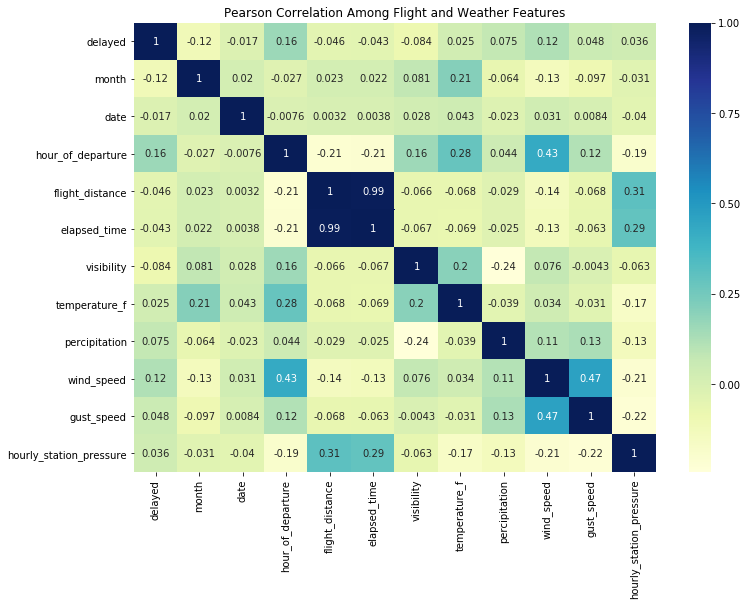

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_and_save_correlation_image(correlation_matrix):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    plt.title("Pearson Correlation Among Flight and Weather Features")
    sns.heatmap(correlation_matrix, ax=ax, annot=True,  cmap="YlGnBu")
    plt.show()
    
plot_and_save_correlation_image(features.corr())

There High levels of correlation between elapsed time and flight distance (i.e. a flight that travels further will be in the air longer.)

In [24]:
y = features['delayed']
X = features.drop('delayed', axis=1)

In [47]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

def conduct_grid_search_and_report_metrics(X, y, param_grid, pipeline, scoring='accuracy', random_state=12):
    """Conducts a grid search with supplied parameters, reports out related metrics"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Create GridSearch, set the specififed scoring metric
    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring=scoring)
    
    # Conduct Gridsearch
    grid.fit(X=X_train, y=y_train)
    
    # Use the fitted grid to predict 
    y_pred = grid.predict(X_test)
    
    print(f"Scoring Methodology:", scoring)
    print(f"         Best Score:", grid.best_score_)
    print("\nTest Set Results ")
    print("Accuracy:", accuracy_score(y_pred=y_pred, y_true=y_test))
    print(classification_report(y_pred=y_pred, y_true=y_test))
    
    print("\nBest Estimator")
    print(grid.best_estimator_)
    
    # Return the fitted grid for use/inspection
    return grid, X_test, y_test

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
    
parameters = [
    {
        'classify': [RandomForestClassifier()],
        'classify__class_weight': ['balanced', 'balanced_subsample', None],
        'classify__criterion': ['gini', '']
        'classify__max_features': ['auto', 'log2'],
        'classify__max_depth': [2, 10, 15],
        
    },
    {
        'approximate': [RBFSampler()],
        'classify': [SGDClassifier()],
        'classify__max_iter': [5],
        'classify__class_weight': ['balanced']
    }
]

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest()),
    ('approximate', None),
    ('classify', None)
])

In [50]:
grid, X_test, y_test = conduct_grid_search_and_report_metrics(X, y, parameters, pipeline, scoring='roc_auc')

Scoring Methodology: roc_auc
         Best Score: 0.777848813348203

Test Set Results 
Accuracy: 0.7761121267519805
             precision    recall  f1-score   support

          0       0.88      0.83      0.85     19401
          1       0.48      0.58      0.52      5214

avg / total       0.79      0.78      0.78     24615


Best Estimator
Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=10, score_func=<function f_classif at 0x10b799d08>)), ('approximate', None), ('classify', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_d...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])


In [53]:
y_score = grid.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [45]:
def plot_auc_roc_curve(roc_auc, false_positive_rate, true_positive_rate):
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()